In [409]:
import numpy as np
from scipy.sparse import csr_matrix,linalg
import matplotlib.pyplot as plt

#System size
L = 2 #Hilbert space dimension is 2**L

#Constructing z-basis states
bin_set=[]
for i in range(2**L, 2**(L+1)):
    bin_set.append(bin(i)[3:])

basis=[]
for binary in bin_set:
    basis.append([int(digits) for digits in binary][::-1])

#0-theta, 0-phi eigenket generator
def eigenket(index):
    output = np.zeros(2**L).astype(complex)
    output[index] = 1
    return output
    
#Initial state
ground_zero = np.zeros(2**L)
ground_zero[2**L-1] = 1

# ground_zero = np.zeros(2**L)
# ground_zero[0] = 1

#Test initial state
test = np.arange(2**L)

In [410]:
#Setting the permutation action of spin operators
def flipper(bin_seq,subspace):
    output = np.empty(len(bin_seq))
    output[:] = bin_seq[:] 
    if output[subspace] == 0:
        output[subspace] = 1
    else:
        output[subspace] = 0 
    return output.astype(int)

pre_flipped_assign = np.array([np.array([flipper(binary,sbspce) for binary in basis]) for sbspce in range(L)])
dec_converter = np.array([2**n for n in range(L)])
multiplied = dec_converter*pre_flipped_assign

#Cheat sheet for the sigma function
permutations = np.array([[np.sum(bin_arrays) for bin_arrays in multiplied[sbspce]] for sbspce in range(L)]).astype(int)
tracker = 2*(np.array(basis).transpose()-1/2) #Records the initial state of flipped state. "0" states are mapped to -1, "1 states are mapped to +1".

#Defining the spin operators
def sigma(vector,*xyz_subspace):
    global L, permutations, tracker
    
    input_vec = np.empty(2**L).astype(complex)
    input_vec[:] = vector[:]
    output = np.empty(2**L).astype(complex)
    
    
    for entry in xyz_subspace[::-1]:
        xyz = entry[0]
        subspace = entry[1]
        
        if subspace == L: #Imposing periodic boundary condition
            subspace = 0
        
        for i in range(2**L):
            if xyz == 1: #spin x
                output[permutations[subspace,i]] = input_vec[i]

            if xyz == 2: #spin y
                output[permutations[subspace,i]] = (1j*input_vec*tracker[subspace])[i]

            if xyz == 3: #spin z
                output[i] = (input_vec*tracker[subspace])[i]
        
        input_vec[:] = output[:]

    return output

#Constructing a function that adds sigma maps
def sigma_add(vector,*xyz_subspace_set):
    output = np.zeros(2**L).astype(complex)
    
    for xyz_subspace in xyz_subspace_set:
        output[:] += sigma(vector,*xyz_subspace)
        
    return output

In [411]:
#Defining the alpha function
def alpha_num(theta,phi,h=1,J=1):
    return h**2*(2*h**4*np.cos(theta)**6*np.cos(phi)+2*h**4*np.sin(theta)**6*np.cos(phi)**5+2*h**4*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)+2*h**4*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**5+4*h**4*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**3+4*h**4*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**3+h**2*J**2*np.cos(theta)**4*np.cos(phi)+6*h**2*J**2*np.sin(theta)**4*np.cos(phi)**3+9*h**2*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)+7*h**2*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)**3+4*J**4*np.sin(theta)**2*np.cos(phi))
def alpha_denom(theta,phi,h=1,J=1):
    return 2*h**6*np.sin(theta)**6*np.cos(phi)**6+6*h**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**4+6*h**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**2+2*h**6*np.cos(theta)**6+6*h**4*J**2*np.sin(theta)**4*np.cos(phi)**4+30*h**4*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)**2-3*h**4*J**2*np.cos(theta)**4+12*h**2*J**4*np.sin(theta)**2*np.cos(phi)**2+14*h**2*J**4*np.cos(theta)**2+8*J**6
def alpha(theta,phi,h=1,J=1):
    return alpha_num(theta,phi,h,J)/alpha_denom(theta,phi,h,J)

In [412]:
#Defining the beta funnction
def beta_num(theta,phi,h=1,J=1):
    return h**3*J*(4*h**2*np.sin(theta)**5*np.cos(phi)**4-5*h**2*np.sin(theta)**3*np.cos(theta)**2*np.cos(phi)**2+7*h**2*np.sin(theta)**3*np.cos(theta)**2*np.cos(phi)**4-2*h**2*np.sin(theta)*np.cos(theta)**4*np.cos(phi)**2+4*J**2*np.sin(theta)**3*np.cos(phi)**2+6*J**2*np.sin(theta)*np.cos(theta)**2*np.cos(phi)**2)
def beta_denom(theta,phi,h=1,J=1): 
    return 2*(2*h**6*np.sin(theta)**6*np.cos(phi)**6+6*h**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**4+6*h**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**2+2*h**6*np.cos(theta)**6+6*h**4*J**2*np.sin(theta)**4*np.cos(phi)**4+30*h**4*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)**2-3*h**4*J**2*np.cos(theta)**4+12*h**2*J**4*np.sin(theta)**2*np.cos(phi)**2+14*h**2*J**4*np.cos(theta)**2+8*J**6)
def beta(theta,phi,h=1,J=1):
    return beta_num(theta,phi,h,J)/beta_denom(theta,phi,h,J)

In [413]:
#Defining the gamma function
def gamma_num(theta,phi,h=1,J=1):
    return -(512*h**9*J**2*np.cos(theta)**10*np.cos(phi)+1024*h**9*J**2*np.sin(theta)**2*np.cos(theta)**8*np.cos(phi)-2*h**9*J**2*np.sin(theta)**8*np.cos(theta)**2*np.cos(phi)**9-896*h**9*J**2*np.sin(theta)**2*np.cos(theta)**8*np.cos(phi)**3+20*h**9*J**2*np.sin(theta)**6*np.cos(theta)**4*np.cos(phi)**5-2*h**9*J**2*np.sin(theta)**8*np.cos(theta)**2*np.cos(phi)**5+72*h**9*J**2*np.sin(theta)**4*np.cos(theta)**6*np.cos(phi)**5-384*h**9*J**2*np.sin(theta)**4*np.cos(theta)**6*np.cos(phi)**3+48*h**9*J**2*np.sin(theta)**6*np.cos(theta)**4*np.cos(phi)**5-256*h**7*J**4*np.cos(theta)**8*np.cos(phi)+1536*h**7*J**4*np.sin(theta)**2*np.cos(theta)**6*np.cos(phi)+12*h**7*J**4*np.sin(theta)**6*np.cos(theta)**2*np.cos(phi)**5-896*h**7*J**4*np.sin(theta)**2*np.cos(theta)**6*np.cos(phi)**3+20*h**7*J**4*np.sin(theta)**4*np.cos(theta)**4*np.cos(phi)**5+24*h**7*J**4*np.sin(theta)**6*np.cos(theta)**2*np.cos(phi)**5-384*h**7*J**4*np.sin(theta)**4*np.cos(theta)**4*np.cos(phi)**3-1152*h**5*J**6*np.cos(theta)**6*np.cos(phi)+768*h**5*J**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)-8*h**5*J**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**5-224*h**5*J**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**3-96*h**5*J**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**3-704*h**3*J**8*np.cos(theta)**4*np.cos(phi)+128*h**3*J**8*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)-128*h*J**10*np.cos(theta)**2*np.cos(phi))
def gamma_denom(theta,phi,h=1,J=1):
    return 4*J*np.cos(theta)*(-h**2*np.sin(theta)**2*np.cos(phi)**2+8*h**2*np.cos(theta)**2+4*J**2)**2*(2*h**6*np.sin(theta)**6*np.cos(phi)**6+6*h**6*np.sin(theta)**4*np.cos(theta)**2*np.cos(phi)**4+6*h**6*np.sin(theta)**2*np.cos(theta)**4*np.cos(phi)**2+2*h**6*np.cos(theta)**6+6*h**4*J**2*np.sin(theta)**4*np.cos(phi)**4+30*h**4*J**2*np.sin(theta)**2*np.cos(theta)**2*np.cos(phi)**2-3*h**4*J**2*np.cos(theta)**4+12*h**2*J**4*np.sin(theta)**2*np.cos(phi)**2+14*h**2*J**4*np.cos(theta)**2+8*J**6)
def gamma(theta,phi,h=1,J=1):
    return gamma_num(theta,phi,h,J)/gamma_denom(theta,phi,h,J)

In [414]:
#Constructing the gauge potential for the theta parameter

#Operators coupled with the alpha, beta, and gamma functions
alpha_map_entries = [[[2,i]] for i in range(L)]
beta_map_entries = [[[1,i],[2,i+1]] for i in range(L)]+[[[2,i],[1,i+1]] for i in range(L)]
gamma_map_entries = [[[3,i],[2,i+1]] for i in range(L)]+[[[2,i],[3,i+1]] for i in range(L)]

def alpha_map(vector):
    return sigma_add(vector,*alpha_map_entries)
def beta_map(vector):
    return sigma_add(vector,*beta_map_entries)
def gamma_map(vector):
    return sigma_add(vector,*gamma_map_entries)

#Theta gauge potential
def gauge_theta(vector,theta,phi,h=1,J=1):
    return (1/2)*(alpha(theta,phi,h,J)*alpha_map(vector)+beta(theta,phi,h,J)*beta_map(vector)+gamma(theta,phi,h,J)*gamma_map(vector))

In [415]:
#Constructing theta unitary operators
def unitary_dtheta(vector,dtheta,theta0,phi0,h=1,J=1):
    return vector - 1j*dtheta*gauge_theta(vector,theta0,phi0,h,J)

def propagator_theta(vector,dtheta,steps,theta_init,phi,h=1,J=1):
    output = np.empty([steps+1,2**L]).astype(complex)
    output[0,:] = vector[:]
    
    state = np.empty(2**L).astype(complex)
    state[:] = vector[:]
    theta0 = theta_init
    
    for i in range(1,steps+1):
        output[i,:] = unitary_dtheta(state,dtheta,theta0,phi,h=1,J=1)[:]
        state[:] = output[i,:]
        theta0 += dtheta

    return output

In [416]:
#Constructing the gauge potential for the phi parameter
gauge_phi_entries = [[[3,i]] for i in range(L)]

def gauge_phi(vector):
    return (1/2)*sigma_add(vector,*gauge_phi_entries)

def unitary_phi(vector,phi):
    output = np.empty(2**L).astype(complex)
    output[:] = vector[:] 
    
    for i in range(L):
        output = np.cos(phi/2)*output - 1j*np.sin(phi/2)*sigma(output,[3,i])
    
    return output

In [417]:
#Calculating instantaneous ground states
h = 1
J = 0

#Setting theta data points
theta_start = 0
theta_end = np.pi
theta_data_points = 100 #Not including theta_start (total data points will be *_data_points + 1)
interval_theta = abs(theta_end-theta_start)/theta_data_points

theta_vals = np.linspace(theta_start,theta_end,theta_data_points+1)

#Setting phi data points
phi_start = 0
phi_end = np.pi/2
phi_data_points = 1 #Not including phi_start (total data points will be *_data_points + 1)
interval_phi = abs(phi_end-phi_start)/phi_data_points

phi_vals = np.linspace(phi_start,phi_end,phi_data_points+1)

#Preparing instantaneous ground states (nesting order is phi set then theta set: [phi,theta])
ground_kets = np.array([[unitary_phi(state,phi) for state in propagator_theta(ground_zero,interval_theta,theta_data_points,theta_start,0,h,J)] for phi in phi_vals])

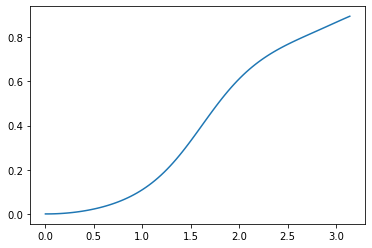

In [418]:
#Calculating g_{phi,phi} data points
#Nesting order is still [phi,theta].
pre_g_phi_phi_term1 = np.array([[gauge_phi(ground_kets[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))])
g_phi_phi_term1 = np.real(np.array([[np.vdot(pre_g_phi_phi_term1[i,j],pre_g_phi_phi_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
g_phi_phi_term2 = np.real(np.array([[np.vdot(ground_kets[i,j],pre_g_phi_phi_term1[i,j])**2 for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
g_phi_phi_vals = g_phi_phi_term1 - g_phi_phi_term2

plt.plot(theta_vals,g_phi_phi_vals[0])
#Change index to see plot at different phi value
plt.show()

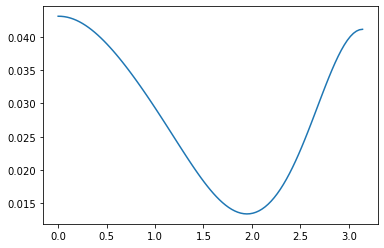

In [118]:
#Calculating g_{theta,theta} data points
#Nesting order is still [phi,theta].
pre_g_theta_theta_term1 = np.array([[gauge_theta(ground_kets[i,j],theta_vals[j],phi_vals[i],h,J) for j in range(len(theta_vals))] for i in range(len(phi_vals))])
#difference of putting phi_vals[i] in gauge_theta(...)
g_theta_theta_term1 = np.real(np.array([[np.vdot(pre_g_theta_theta_term1[i,j],pre_g_theta_theta_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
g_theta_theta_term2 = np.real(np.array([[np.vdot(ground_kets[i,j],pre_g_theta_theta_term1[i,j])**2 for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
g_theta_theta_vals = g_theta_theta_term1 - g_theta_theta_term2

plt.plot(theta_vals,g_theta_theta_vals[0])
#Change index to see plot at different phi value
plt.show()

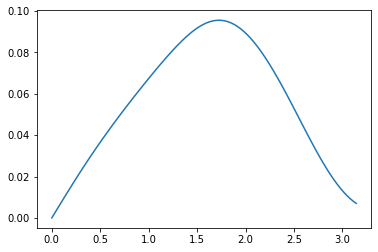

In [119]:
#Calculating the Berry curvature
x_theta_phi_term1 = np.imag(np.array([[np.vdot(pre_g_theta_theta_term1[i,j],pre_g_phi_phi_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
expectation_gauge_theta = np.real(np.array([[np.vdot(ground_kets[i,j],pre_g_theta_theta_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
expectation_gauge_phi = np.real(np.array([[np.vdot(ground_kets[i,j],pre_g_phi_phi_term1[i,j]) for j in range(len(theta_vals))] for i in range(len(phi_vals))]))
x_theta_phi_term2 = expectation_gauge_theta*expectation_gauge_phi
x_theta_phi_vals = x_theta_phi_term1 - x_theta_phi_term2

plt.plot(theta_vals,x_theta_phi_vals[0])
#Change index to see plot at different phi value
plt.show()

Verification tools

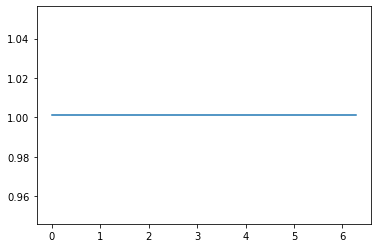

In [120]:
#Sanity check. This is a plot of <0(theta,phi)|0(theta,phi)> vs. phi. We expect a constant unity value for the former.
jj = 9 #theta

plt.plot(phi_vals,[np.real(np.vdot(ground_kets[ii,jj],ground_kets[ii,jj])) for ii in range(len(phi_vals))])
plt.show()

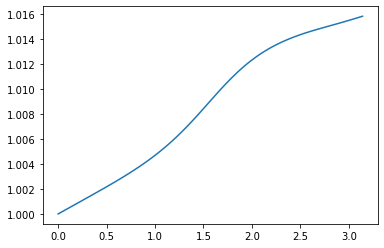

In [121]:
#Sanity check. This is a plot of <0(theta,phi)|0(theta,phi)> vs. theta. We expect a constant unity value for the former.
ii = 0 #phi

plt.plot(theta_vals,[np.real(np.vdot(ground_kets[ii,jj],ground_kets[ii,jj])) for jj in range(len(theta_vals))])
plt.show()

These sanity checks give a positive result (sane). But, at best we just know that the gauge potentials we used here are Hermitian, and not if they are the correct gauge potentials. I am pretty confident the theta gauge potential is correct. I'll check if the phi gauge potential is indeed what the reference claims it to be.

In [419]:
#Sanity check. Permutation checker. Seems correct.
ket_index = 1
xyz = 3
sbspce = 0

eigenket = np.zeros(2**L)
eigenket[ket_index] = 1

def find(vector):
    for i in range(len(vector)):
        if vector[i] != 0+0j:
            output = i
            break
    return output

print(basis[ket_index])
print(sigma(eigenket,[xyz,sbspce]))
print(basis[find(sigma(eigenket,[xyz,sbspce]))])

[1, 0]
[-0.+0.j  1.+0.j -0.+0.j  0.+0.j]
[1, 0]


In [420]:
#Seeking ground state
h_map_x_entries = [[[1,i]] for i in range(L)]
h_map_y_entries = [[[2,i]] for i in range(L)]
h_map_z_entries = [[[3,i]] for i in range(L)]
J_map_entries = [[[3,i],[3,i+1]] for i in range(L)]

def h_map_x(vector):
    return sigma_add(vector,*h_map_x_entries)
def h_map_y(vector):
    return sigma_add(vector,*h_map_y_entries)
def h_map_z(vector):
    return sigma_add(vector,*h_map_z_entries)
def J_map(vector):
    return sigma_add(vector,*J_map_entries)

def hamiltonian(vector,theta,phi,h=1,J=1):
    return -h*(np.cos(theta)*h_map_z(vector)+np.sin(theta)*np.sin(phi)*h_map_y(vector)+np.sin(theta)*np.cos(phi)*h_map_x(vector)) - J*J_map(vector)

def eigenket(index):
    output = np.zeros(2**L)
    output[index] = 1 
    return output

#eigenvalues = np.array([np.real(np.vdot(eigenket(i),hamiltonian(eigenket(i),0,np.pi/2,1,2))) for i in range(2**L)])

def ground_seeker(array):
    output = []
    minimum = np.amin(array)
    
    for i in range(len(array)):
        if array[i] == minimum:
            output.append(i)
            
    return output

In [421]:
h = 1
J = 0
theta = np.pi/2
phi = 0

ham_matrix = np.array([[np.vdot(eigenket(i),hamiltonian(eigenket(j),theta,phi,h,J)) for j in range(2**L)] for i in range(2**L)])
print(np.real(ham_matrix))

[[ 1.2246468e-16 -1.0000000e+00 -1.0000000e+00  0.0000000e+00]
 [-1.0000000e+00  0.0000000e+00  0.0000000e+00 -1.0000000e+00]
 [-1.0000000e+00  0.0000000e+00  0.0000000e+00 -1.0000000e+00]
 [ 0.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.2246468e-16]]


In [422]:
solution = np.linalg.eig(ham_matrix)
eigenvalues = np.real(solution[0])
min_index = np.argmin(eigenvalues)
print(eigenvalues,", index of minimum: ",min_index)
lowest = solution[1][min_index]
normalized_ground = lowest/np.sqrt(np.real(np.vdot(lowest,lowest)))

[ 2.00000000e+00 -2.00000000e+00  4.97899625e-17  2.07621791e-33] , index of minimum:  1


In [423]:
normalized_ground

array([-0.46501802+0.j,  0.46501802-0.j, -0.3674683 +0.j,  0.6576348 +0.j])

In [424]:
theta_vals[50]

1.5707963267948968

In [425]:
phi_vals

array([0.        , 1.57079633])

In [426]:
candidate = ground_kets[0,50]

In [427]:
hamiltonian(candidate,theta,phi,h,J)

array([-0.60776122+0.j, -1.13930727+0.j, -1.13930727+0.j, -0.60776122+0.j])

In [429]:
candidate*(-2)

array([-0.55138153+0.j, -0.60776122+0.j, -0.60776122+0.j, -1.72723301+0.j])

In [434]:
hamiltonian(normalized_ground,theta,phi,h,J)

array([-0.09754973+0.j, -0.19261677+0.j, -0.19261677+0.j, -0.09754973+0.j])

In [435]:
normalized_ground*(-2)

array([ 0.93003605-0.j, -0.93003605+0.j,  0.73493659-0.j, -1.31526959+0.j])

In [436]:
np.vdot(candidate,candidate)

(1.0065257128172824+0j)

In [438]:
basis[::-1]

[[1, 1], [0, 1], [1, 0], [0, 0]]

In [440]:
bin_set

['00', '01', '10', '11']

array([[1, 1],
       [0, 1],
       [1, 0],
       [0, 0]])

In [446]:
basis

[[0, 0], [1, 0], [0, 1], [1, 1]]

In [450]:
bin_set

['00', '01', '10', '11']

In [454]:
pre_basis=[]
for binary in bin_set:
    pre_basis.append([int(digits) for digits in binary])

In [457]:
basis = np.ones_like(basis)-np.array(pre_basis)

In [458]:
basis

array([[1, 1],
       [1, 0],
       [0, 1],
       [0, 0]])

In [459]:
multiplied

array([[[1, 0],
        [0, 0],
        [1, 2],
        [0, 2]],

       [[0, 2],
        [1, 2],
        [0, 0],
        [1, 0]]])